In [121]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# Read Dataframe to get data
df = pd.read_csv('AAPL_2023.csv')
price_column = df['close']
unchanged_stock_prices = price_column.to_numpy() 
stock_prices = (unchanged_stock_prices - np.min(unchanged_stock_prices)) / (np.max(unchanged_stock_prices) - np.min(unchanged_stock_prices))

# Convert to PyTorch tensors and reshape for LSTM
sequence_length = 10
x_train, y_train = [], []

for i in range(len(stock_prices) - sequence_length):
    x_train.append(stock_prices[i:i + sequence_length])
    y_train.append(stock_prices[i + sequence_length])

# Reshape for LSTM
x_train = torch.tensor(x_train, dtype=torch.float32).view(-1, sequence_length, 1)  
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

In [122]:
# Define LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Create hidden layer and cell layer
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) 
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Fully connected layer 
        out = self.fc(out[:, -1, :])  
        return out

In [123]:
# Initialize model, loss, and optimizer
input_size = 1        # Each week has 1 stock price
hidden_size = 64      # Number of LSTM units
output_size = 1       # Predicting 1 stock price
num_layers = 2        # Double LSTM layer
learning_rate = 0.001
num_epochs = 100

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [124]:
# Training
for epoch in range(num_epochs):
    model.train()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print statement for debug and loss
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [125]:
# Testing on the training data

# Future: use training data to predict October 2023
model.eval()
predicted = model(x_train).detach().numpy()

In [126]:
# Output results to csv
results = df[['Date', 'open']]
results = results.set_index('Date')
nan_array = np.full(10, np.nan)
nan_array = nan_array.reshape(-1, 1)
predicted = np.round(predicted * (np.max(unchanged_stock_prices) - np.min(unchanged_stock_prices)) + np.min(unchanged_stock_prices), 2)

predicted = np.concatenate([nan_array, predicted])
results['predicted'] = predicted
results.to_csv('results.csv', index = True, na_rep = 'NA')

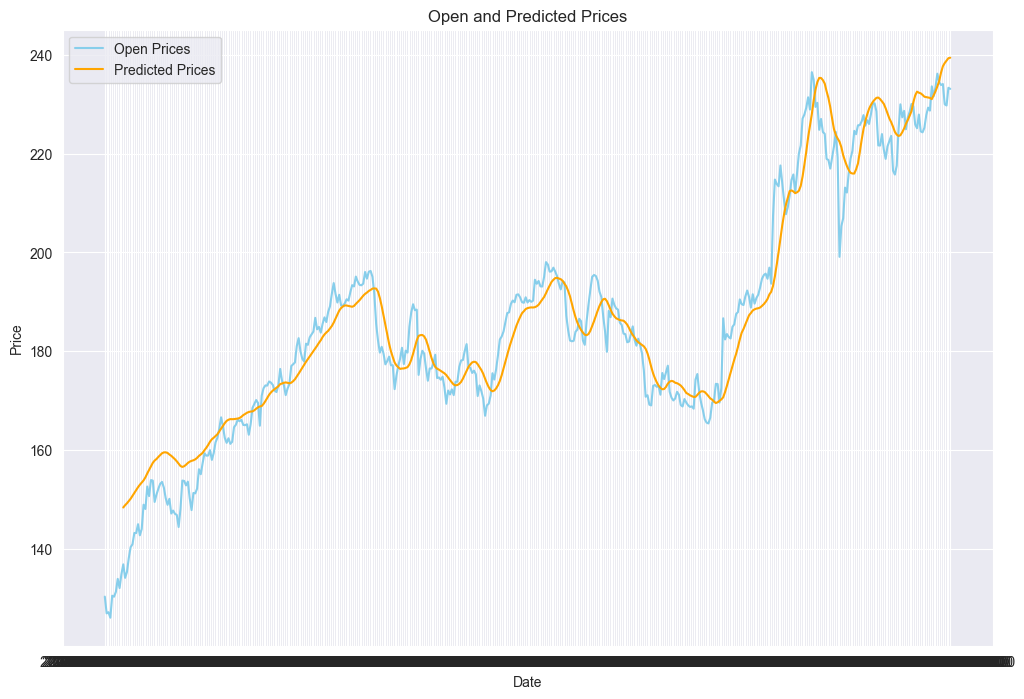

In [129]:
# Load the results file
results = pd.read_csv('results.csv')

# Plotting
plt.figure(figsize=(12, 8))

# Plot Close values
plt.plot(results['Date'], results['open'], label='Open Prices', color='skyblue')

# Plot Predicted values
plt.plot(results['Date'], results['predicted'], label='Predicted Prices', color='orange')

# Customizing plot
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Open and Predicted Prices')
plt.legend()


plt.show()